# Install libraries

In [ ]:
!pip install catboost -qq
!pip install dataprep -qq
!pip install optuna -qq

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from dataprep.eda import *

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import optuna
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm_notebook
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

# Load data

In [34]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [35]:
test_id = test['Id'] # save ID from test dataset for submission

In [36]:
df = pd.concat([train, test])

df.drop(['Id'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


# Review data by dataprep

Report with train ant test datasets differences

In [ ]:
diff_report = plot_diff([train, test],
          config={"diff.label": ["train", "test"],
                  "diff.density": True})

diff_report.save(filename='diff_report.html')

# diff_report

Profile report from a train dataset

In [ ]:
report_train = create_report(train, title='DF_train_dataprep_report')

report_train.save()

# report_train

# Missing values

In [37]:
# The list of features with missing values

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)


missing_data = pd.concat([total, percent],
                         axis=1,
                         keys=['Total', 'Percent'])

missing_data[missing_data['Total'] > 0]

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageFinish,159,0.054471
GarageQual,159,0.054471


_PoolQC_ has a high percentage of missing data.

_Street_ and _Utilities_ are low informative.

In [38]:
df.drop(['PoolQC', 'Street','Utilities'], axis=1, inplace=True)

NaN in _MiscFeature_, _Alley_, _Fence_ fill with 'None'

In [39]:
df['MiscFeature'].fillna('None', inplace=True)
df['Alley'].fillna('None', inplace=True)
df['Fence'].fillna('None', inplace=True)

<AxesSubplot:xlabel='Fence', ylabel='Count'>

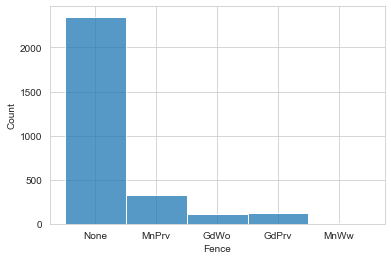

In [40]:
sns.histplot(df['Fence'])

The most popular value in _MasVnrArea_ is zero so lets fill nan by zeros

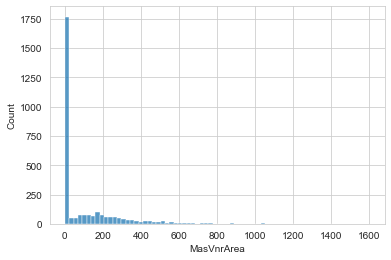

In [41]:
sns.histplot(df['MasVnrArea'])

df['MasVnrArea'].fillna(0, inplace=True)

The most popular value in _MasVnrType_ in None. Lets fill missing values with Nones

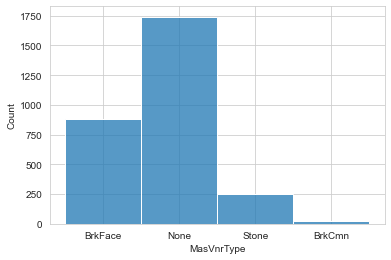

In [42]:
sns.histplot(df['MasVnrType'])

df['MasVnrType'].fillna('None', inplace=True)

For [_GarageType_, _GarageFinish_, _GarageQual_, _GarageCond_ ] features add a new value NONE 

In [43]:
gar_str_col = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

df[gar_str_col] = df[gar_str_col].fillna('None')

Same operation make with _FireplaceQu_

In [44]:
print(df['FireplaceQu'].value_counts())

df['FireplaceQu'].fillna('None', inplace=True)

Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64


Lets fill missing value in _GarageYrBlt_ with obvious outliers = 0

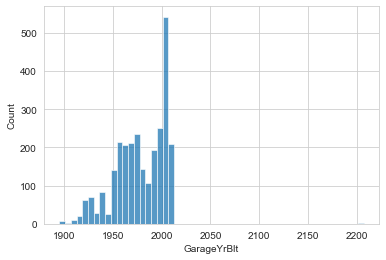

In [45]:
sns.histplot(df['GarageYrBlt'])

df['GarageYrBlt'].fillna(0, inplace=True)

Investigation _LotFontage_ feature

<AxesSubplot:xlabel='LotFrontage', ylabel='Neighborhood'>

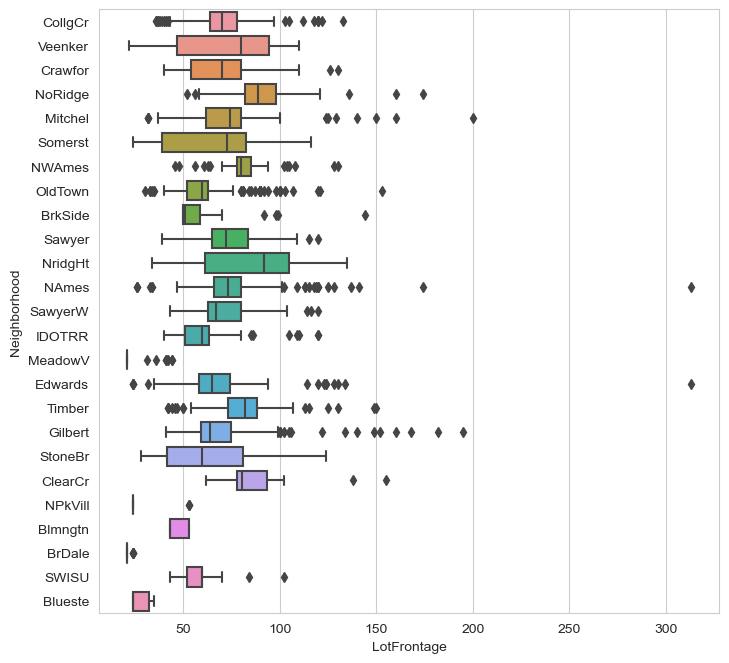

In [46]:
plt.figure(figsize=(8, 8), dpi=100)
sns.boxplot(data=df, x='LotFrontage', y='Neighborhood', orient='h')

Lets fill na in _LotFrontage_ with mean aggregation by _Neighborhood_

In [47]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda value: value.fillna(value.mean()))

BSMT features

In [48]:
# BSMT Numberic columns -> fillna 0
bsmt_num_cols = ['BsmtFinSF1', 'BsmtFinSF2','TotalBsmtSF', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath']
df[bsmt_num_cols] = df[bsmt_num_cols].fillna(0)

# BSMT String columns -> fillna 'None'
bsmt_str_cols =  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df[bsmt_str_cols] = df[bsmt_str_cols].fillna('None')

Other features fill with mode values

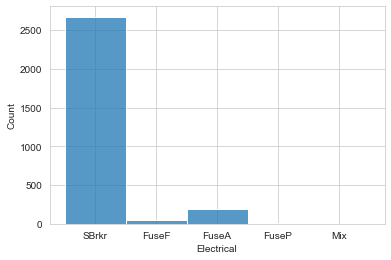

In [49]:
sns.histplot(df['Electrical'])

df['Electrical'].fillna('SBrkr', inplace=True)

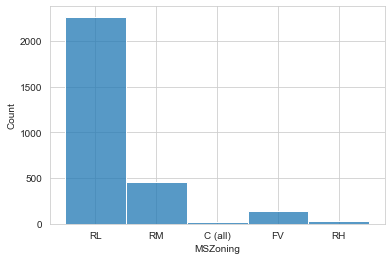

In [50]:
sns.histplot(df['MSZoning'])

df['MSZoning'].fillna('RL', inplace=True)

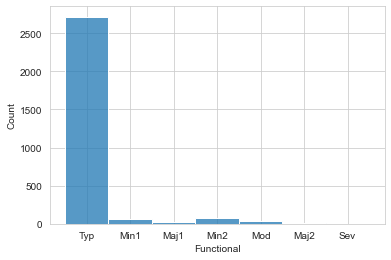

In [51]:
sns.histplot(df['Functional'])

df['Functional'].fillna('Typ', inplace=True)

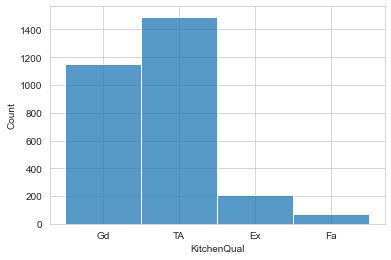

In [52]:
sns.histplot(df['KitchenQual'])

df['KitchenQual'].fillna('TA', inplace=True)

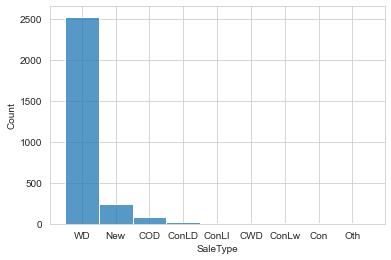

In [53]:
sns.histplot(df['SaleType'])

df['SaleType'].fillna('WD', inplace=True)

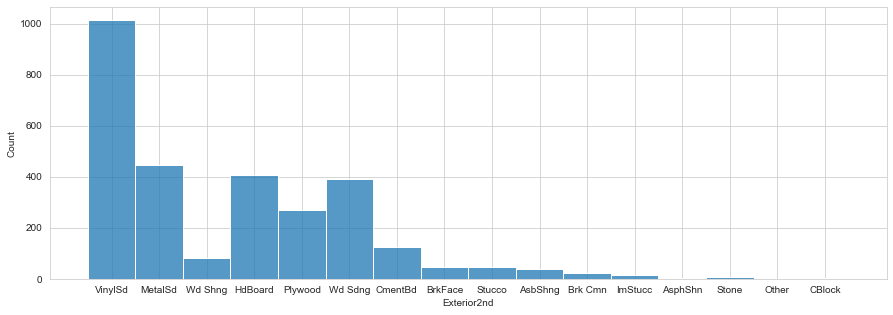

In [54]:
plt.figure(figsize=(15, 5))
sns.histplot(df['Exterior2nd'])

df['Exterior2nd'].fillna('VinylSd', inplace=True)

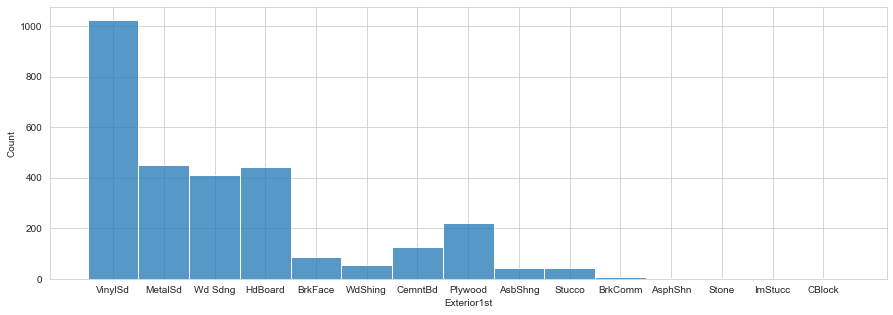

In [55]:
plt.figure(figsize=(15, 5))
sns.histplot(df['Exterior1st'])

df['Exterior1st'].fillna('VinylSd', inplace=True)

Due to set _GarageYrBlt_ = zero, also set zero for _GarageCars_ and _GarageArea_

In [56]:
df[df['GarageCars'].isnull()]

df['GarageCars'].fillna(0, inplace=True)
df['GarageArea'].fillna(0, inplace=True)

# Remove outliers

## SalePrice

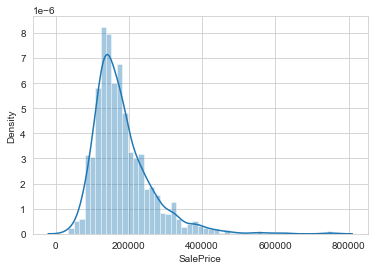

In [57]:
sns.distplot(df['SalePrice'], kde=True, hist=True);

Values more than 6 sigma [7.22881942 7.10289909]


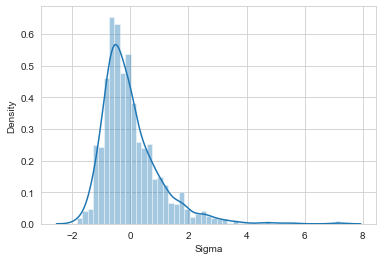

In [58]:
sale_price = StandardScaler().fit_transform(df['SalePrice'][:,np.newaxis])

print(f'Values more than 6 sigma {sale_price[sale_price>6]}')
plt.xlabel('Sigma')
sns.distplot(sale_price, kde=True, hist=True);

There are 2 outliers (more than 6 sigma) and they will be deleted further

## GrLivArea

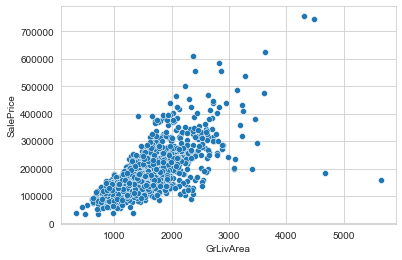

In [59]:
# GrLivArea vs SalePrice scatterplot

sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')

# remove outliers:
# two GrLivArea < 4000 - low price for high area
# two by SalePrice - deviation more than 6 sigma 
df.drop([523, 691, 1182, 1298], axis=0, inplace=True)

## Scaling _SalePrice_

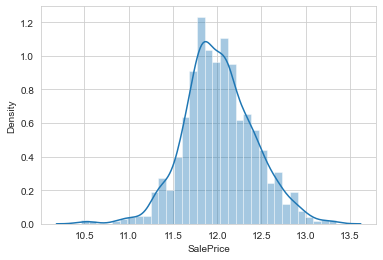

In [60]:
y_log = np.log1p(df['SalePrice'].dropna())
df.drop('SalePrice', axis=1, inplace=True)

sns.distplot(y_log, kde=True, hist=True);

# Add new features

In [61]:
# Years since remodel
df['YearRemod'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype(int)

# Total home quality
df['TotalQuality'] = df['OverallQual'] + df['OverallCond']

# Total home square feets
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Total porch square feets
df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

# Total
df['TotalBaths'] = df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath']

In [62]:
drop_feat = ['YrSold', 'YearRemodAdd', 'OverallQual',
             'OverallCond', 'TotalBsmtSF', '1stFlrSF',
             '2ndFlrSF', 'OpenPorchSF', '3SsnPorch',
             'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF',
             'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

df.drop(drop_feat, axis=1, inplace=True)

# Remove feature with high multicollinearity 

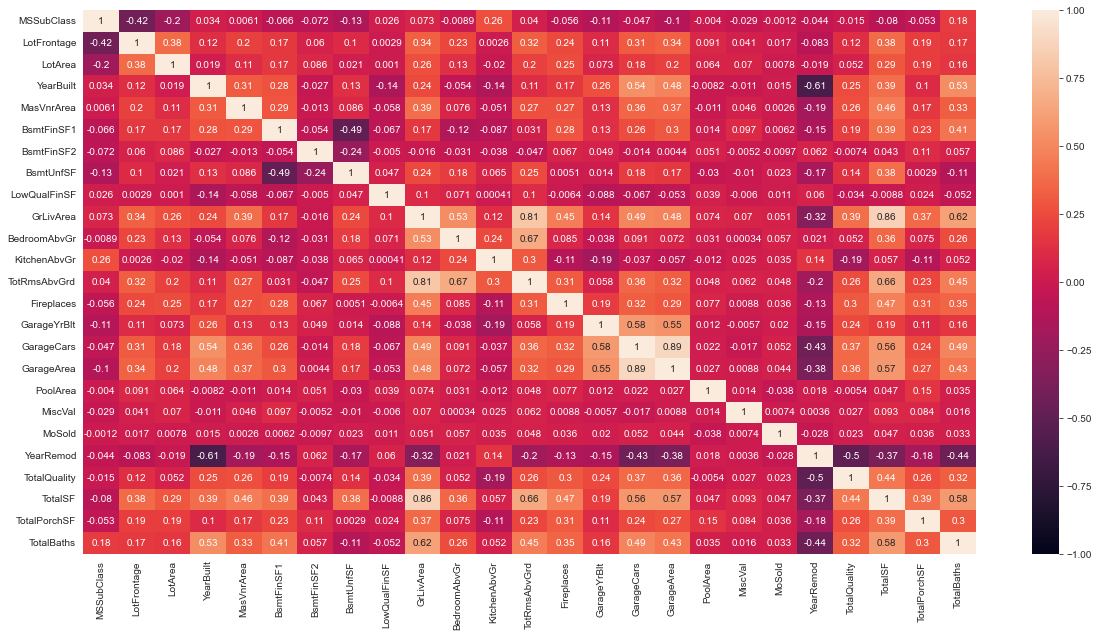

In [63]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

In [64]:
# TotRmsAbvGrd and TotalSF have carellation (0.81 and 0.86) to GrLivArea feature
df.drop(['GrLivArea'], axis=1, inplace=True)

# Clustering

In [65]:
categorical_feat = []
numerical_feat = []

for i in df.columns:
    if df[i].dtype == np.float64 or df[i].dtype == np.int64:
        if i != 'MSSubClass' or i != 'OverallQual' or i != 'Fireplaces':
            numerical_feat.append(i)
        else: 
            categorical_feat.append(i)
    else:
        categorical_feat.append(i)

In [66]:
X = StandardScaler().fit_transform(df[numerical_feat])

In [67]:
pca = PCA(n_components=3)
tsne = TSNE(n_components=3, perplexity=15, random_state=42)

In [68]:
X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)

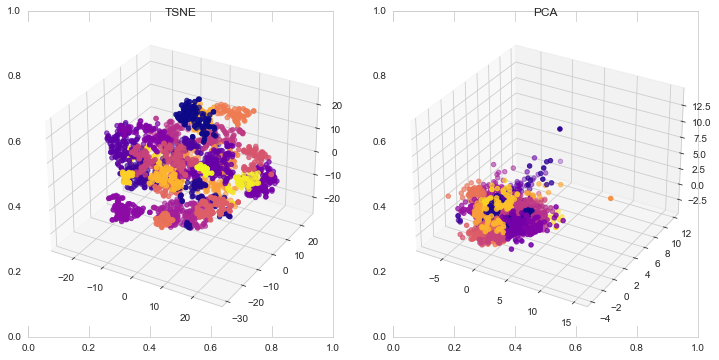

In [69]:
ag = AgglomerativeClustering(32)
ag_tsne = ag.fit_predict(X_tsne)
ag_pca = ag.fit_predict(X_pca)

# Draw
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')

ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c = ag_tsne, cmap='plasma')
ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = ag_pca, cmap='plasma')

ax1.set_title('TSNE')
ax2.set_title('PCA');

In [70]:
df['Cluster'] = ag_pca

# Feature encoding and train/test split

In [71]:
df_encoded = pd.get_dummies(df, columns=categorical_feat)

In [72]:
df_train = df_encoded[:len(y_log)]
df_test = df_encoded[len(y_log):]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y_log, test_size=0.2, random_state=42)

# Simple model (Linear Regression)

In [74]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

lr_model_score = mean_squared_error(y_test, y_pred, squared=True)
print(f'Linear Regression mse = {lr_model_score}')

Linear Regression mse = 0.01819997989734746


# Tuning models (LightGBM, XGBoost, CatBoost)

## LGBMRegressor

In [75]:
def objective_lgbm(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    params = {
              'metric': 'rmse', 
              'random_state': 42,
              'n_estimators': trial.suggest_int('n_estimators', 500, 5001, 500),
              'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.85]),
              'subsample': trial.suggest_categorical('subsample', [0.6,0.65,0.7,0.75,0.8,0.85]),
              'learning_rate': trial.suggest_categorical('learning_rate',[0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
              'max_depth': trial.suggest_categorical('max_depth', [-1,10,20,30]),
              'num_leaves' : trial.suggest_int('num_leaves', 2, 300),
              'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
              'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }

    model = LGBMRegressor(**params)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    y_pred = model.predict(X_test)
    
    metric = mean_squared_error(y_test, y_pred, squared=True)
    
    return metric

In [78]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lgbm = optuna.create_study(direction='minimize')

study_lgbm.optimize(objective_lgbm,
                    n_trials=100,
                    n_jobs=-1,
                    timeout=10000,
                    show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [79]:
print(f'Best score:', study_lgbm.best_trial.value)
print(f'Best parameters: {study_lgbm.best_params}\n')
optuna.visualization.plot_optimization_history(study_lgbm)

Best score: 0.01610611096250029
Best parameters: {'n_estimators': 3500, 'colsample_bytree': 0.6, 'subsample': 0.65, 'learning_rate': 0.015, 'max_depth': 20, 'num_leaves': 51, 'min_child_samples': 7, 'min_data_per_groups': 44}



## XGBoost

In [80]:
def objective_xgbr(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    params = {
              'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
              'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.01, 0.06, 0.005),
              'n_estimators': trial.suggest_int('n_estimators', 500, 5001, 500),
              'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13,15,17,20,30]),
              'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
              'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
              'objective' : trial.suggest_categorical('objective', ['reg:squarederror'])
    }

    model = XGBRegressor(**params)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    y_pred = model.predict(X_test)
    
    metric = mean_squared_error(y_test, y_pred, squared=True)
    
    return metric

In [81]:
study_xgbr = optuna.create_study(direction='minimize')

study_xgbr.optimize(objective_xgbr,
                    n_trials=10,
                    n_jobs=-1,
                    timeout=10000,
                    show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
print(f'Bbest score: ', study_xgbr.best_trial.value)
print(f'Best parameters: {study_xgbr.best_params}\n')
optuna.visualization.plot_optimization_history(study_xgbr)

Bbest score:  0.014078797938396484
Best parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'n_estimators': 2000, 'max_depth': 30, 'subsample': 0.6, 'random_state': 24, 'objective': 'reg:squarederror'}



## Catboost

In [83]:
def objective_catb(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    param = {'learning_rate': trial.suggest_discrete_uniform("learning_rate", 0.01, 0.06, 0.005),
            'depth' : trial.suggest_int('depth', 2, 16, 1),
            'min_child_samples' : trial.suggest_categorical('min_child_samples', [1, 2, 4, 8, 12, 16, 20, 25]),
            'iterations' : trial.suggest_int('iterations', 500, 3501, 500),
            'l2_leaf_reg' : trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 15.0, 1),
            'use_best_model' : True,
            'eval_metric' : 'MSLE',
            'od_wait' : 20,
            'random_state' : 42,
            'logging_level' : 'Silent'
    }

    model = CatBoostRegressor(**param)
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    y_pred = model.predict(X_test)
    
    metric = mean_squared_error(y_test, y_pred, squared=True)
    
    return metric

In [84]:
study_catb = optuna.create_study(direction='minimize')

study_catb.optimize(objective_catb,
                    n_trials=10,
                    n_jobs=-1,
                    timeout=10000,
                    show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [85]:
print(f'Best score:', study_catb.best_trial.value)
print(f'Best parameters: {study_catb.best_params}\n')
optuna.visualization.plot_optimization_history(study_catb)

Best score: 0.014392900812611631
Best parameters: {'learning_rate': 0.04, 'depth': 7, 'min_child_samples': 2, 'iterations': 3000, 'l2_leaf_reg': 5.0}



## Summary

In [86]:
print(f'Linear Regression score : {lr_model_score}')
print(f'LightGBM best score: {study_lgbm.best_trial.value}')
print(f'XGBoost best score: {study_xgbr.best_trial.value}')
print(f'Catboost best score: {study_catb.best_trial.value}')

Linear Regression score : 0.01819997989734746
LightGBM best score: 0.01610611096250029
XGBoost best score: 0.014078797938396484
Catboost best score: 0.014392900812611631


# Pseudo labeling

In [89]:
def pseudo_labeling(model, epochs=100):
    '''
    Improve model’s output in small dataset.
    '''

    for i in tqdm_notebook(range(epochs)):

        if i==0:
            model.fit(df_train, y_log)
            y_pred = model.predict(df_test)
            
        else:
            y = np.concatenate([y_log, y_pred])
            model.fit(df_encoded.values, y)
            y_pred = model.predict(df_test)

    return y_pred        

In [91]:
XGB_model = XGBRegressor(colsample_bytree=0.4,
                         learning_rate=0.05,
                         n_estimators=2000,
                         max_depth=30,
                         subsample=0.6,
                         random_state=24,
                         objective='reg:squarederror')

y_pred = pseudo_labeling(model=XGB_model, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

# Prediction to csv file

In [93]:
df_predicted = pd.DataFrame(index = test_id, data = np.expm1(y_pred), columns = ['SalePrice'])
df_predicted.to_csv(f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.csv')